# Rolling Window Forecasting Experiment

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install ema-pytorch==0.2.1;pandas==1.5.0;scikit-learn==1.1.2;scipy==1.8.1;seaborn==0.12.2;tqdm==4.64.1;dm-control==1.0.12;dm-env==1.6;dm-tree==0.1.8;mujoco==2.3.4;gluonts==0.12.6;pyyaml==6.0
import os
import torch
import numpy as np
import sys

sys.path.insert(0,'/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS')
from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

from Utils.metric_utils import display_scores
from Utils.discriminative_metric import discriminative_score_metrics
from Utils.predictive_metric import predictive_score_metrics

import itertools
import yaml
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

from Utils.cross_correlation import CrossCorrelLoss
!pip install gluonts
import warnings
warnings.filterwarnings("ignore")


from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one, unnormalize_to_zero_to_one

Mounted at /content/drive
/bin/bash: line 1: scikit-learn==1.1.2: command not found
/bin/bash: line 1: dm-control==1.0.12: command not found
/bin/bash: line 1: dm-env==1.6: command not found
/bin/bash: line 1: dm-tree==0.1.8: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 49.9 MB/s eta 0:00:00


In [2]:
import pandas as pd

ori_path = os.path.join('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro.csv')
#data_sliced = np.load('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/grid_search/batch_size64_n_heads8_d_model96_timesteps1000/samples/macro_ground_truth_24_train.npy')

data = pd.read_csv(ori_path)

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import os

# --- 1) Data Preparation ---
train = data

test = data[360:411]

scaler = MinMaxScaler()
train_scaled = normalize_to_neg_one_to_one(scaler.fit_transform(train))
test_scaled =normalize_to_neg_one_to_one(scaler.transform(test))

# --- 2) Sliding Window Helper ---
def create_windows(series, window_size):
    """
    Slices a time series into non-overlapping sequences of a specified size.

    Args:
        series (np.ndarray): The input time series data (time_points, features).
        window_size (int): The desired length of each sequence.

    Returns:
        np.ndarray: An array of non-overlapping sequences (num_sequences, window_size, features).
                    Any leftover data points that don't form a full window are discarded.
    """
    num_time_points = series.shape[0]
    num_features = series.shape[1]
    num_sequences = num_time_points // window_size
    windows = series[:num_sequences * window_size].reshape(num_sequences, window_size, num_features)
    return windows

train_windows = create_windows(train_scaled, 12)

# --- 3) Dataset & Loader ---
class MacroDataset(Dataset):
    def __init__(self, data, regular=True, pred_length=8):
        super(MacroDataset, self).__init__()
        self.sample_num = data.shape[0]
        self.samples = data
        self.regular = regular
        self.mask = np.ones_like(data)
        self.mask[:, -pred_length:, :] = 0.
        self.mask = self.mask.astype(bool)

    def __getitem__(self, ind):
        x = self.samples[ind, :, :]
        if self.regular:
            return torch.from_numpy(x).float()
        mask = self.mask[ind, :, :]
        return torch.from_numpy(x).float(), torch.from_numpy(mask)

    def __len__(self):
        return self.sample_num

dataloader = DataLoader(MacroDataset(train_windows, regular=True), batch_size=4, shuffle=True, num_workers=0, drop_last=True, pin_memory=True, sampler=None)


# --- 4) Load Model ---
class Args_Example:
    def __init__(self):
        self.config_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Config/macro_germany.yaml'
        self.save_dir = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/forecasting_exp'
        self.gpu = 0
        os.makedirs(self.save_dir, exist_ok=True)

args = Args_Example()
configs = load_yaml_config(args.config_path)
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

model = instantiate_from_config(configs['model']).to(device)
trainer = Trainer(config=configs, args=args, model=model, dataloader={'dataloader': dataloader})


In [4]:
trainer.train()#.load(milestone= 1002)

  0%|          | 0/10000 [00:00<?, ?it/s]

training complete


In [12]:
from itertools import product

# --- 1. Parameterbereiche für Grid Search ---
# Define the ranges for the hyperparameters to be used in the grid search.
overlap_list = [3] # List of overlap values
coef_list = [1e-1] # List of coefficient values
stepsize_list = [1e-1] # List of step size values

# Define the directory to save the results of the grid search.
save_dir = "/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/forecasting_exp"
os.makedirs(save_dir, exist_ok=True) # Create the directory if it doesn't exist

# --- 2. Grid Search ---
# Iterate over all possible combinations of hyperparameters using product from itertools.
for overlap, coef, stepsize in product(overlap_list, coef_list, stepsize_list):
    print(f"==> Running with overlap={overlap}, coef={coef}, stepsize={stepsize}")

    # Forecast-Konfiguration (Forecast Configuration)
    block_size = 12 # Define the size of the input block for the model
    pred = block_size - overlap # Calculate the prediction length based on block size and overlap
    total_length = 36 # Define the total length of the sequence to generate
    known_length = 12 # Define the length of the known history
    pred_length = total_length - known_length # Calculate the total prediction length
    feat_num = data.shape[-1] # Get the number of features from the data

    # Initialize the generated sequence with the known history from the test data.
    generated_seq = np.copy(test_scaled[:known_length])
    # Reshape the generated sequence to have an extra dimension for consistency.
    temp = create_windows(generated_seq, 1)
    generated_seq = np.expand_dims(temp[:, 0, :], axis=0)

    # Generate the sequence iteratively using a rolling window approach.
    while generated_seq.shape[1] < total_length:
        # Get the context window from the generated sequence.
        context = generated_seq[:, -block_size:, :]

        # Create a dataset and dataloader for the current context.
        ds = MacroDataset(context, regular=False, pred_length=pred)
        loader = DataLoader(ds, batch_size=1, shuffle=False)

        # Use the trained model to generate the next block of data.
        sample_block, *_ = trainer.restore(
            loader, shape=[block_size, feat_num],
            coef=coef, stepsize=stepsize, sampling_steps=200 # Parameters for the sampling process
        )

        # Extract the predicted part from the generated block.
        new_data = sample_block[:, :pred]
        # Concatenate the new data to the generated sequence.
        generated_seq = np.concatenate([generated_seq, new_data], axis=1)

    # Trim the generated sequence to the desired total length.
    full_gen = generated_seq[:, :total_length]
    # Inverse transform the generated sequence back to the original scale.
    gen_real = scaler.inverse_transform(unnormalize_to_zero_to_one(np.squeeze(full_gen, axis=0)))

    # --- 3. Plotten & Speichern (Plotting & Saving) ---
    # Create a directory to save plots for the current parameter combination.
    param_dir = f"overlap{overlap}_coef{coef:.0e}_step{stepsize:.0e}"
    full_path = os.path.join(save_dir, param_dir)
    os.makedirs(full_path, exist_ok=True)

    # Plot and save the results for each feature.
    '''for idx in range(feat_num):
        plt.figure(figsize=(15, 3))
        # Plot the historical data.
        plt.plot(range(0, 101), test.iloc[:101, idx], color='c', label='History')
        # Plot the ground truth data for the prediction period.
        plt.plot(range(100, total_length), test.iloc[100:total_length, idx], color='g', label='Ground Truth')
        # Plot the generated prediction.
        plt.plot(range(95, total_length), gen_real[95:total_length, idx], color='r', label='Prediction', alpha=0.5)
        plt.title(f'Feature {idx}') # Set the title of the plot
        plt.legend() # Display the legend
        plt.savefig(os.path.join(full_path, f"feature_{idx}.png")) # Save the plot
        plt.close() # Close the plot to free up memory'''

==> Running with overlap=3, coef=0.1, stepsize=0.1


conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

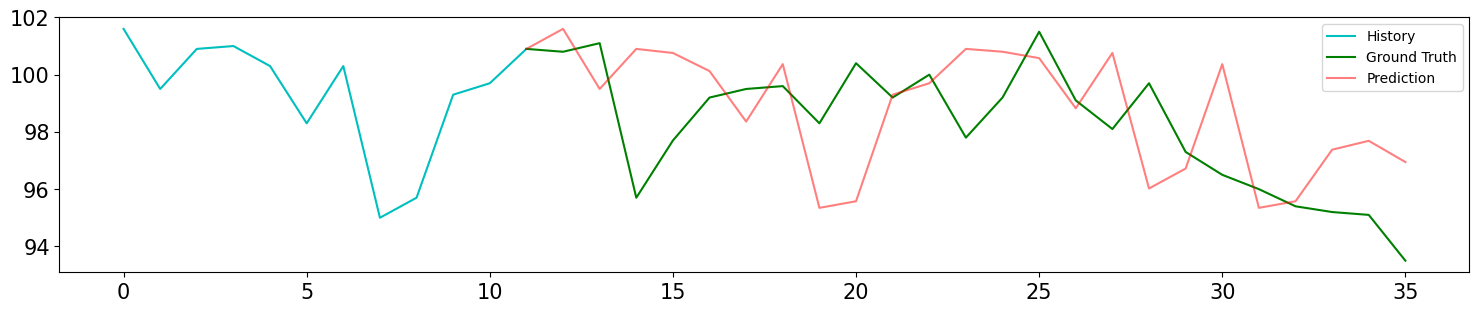

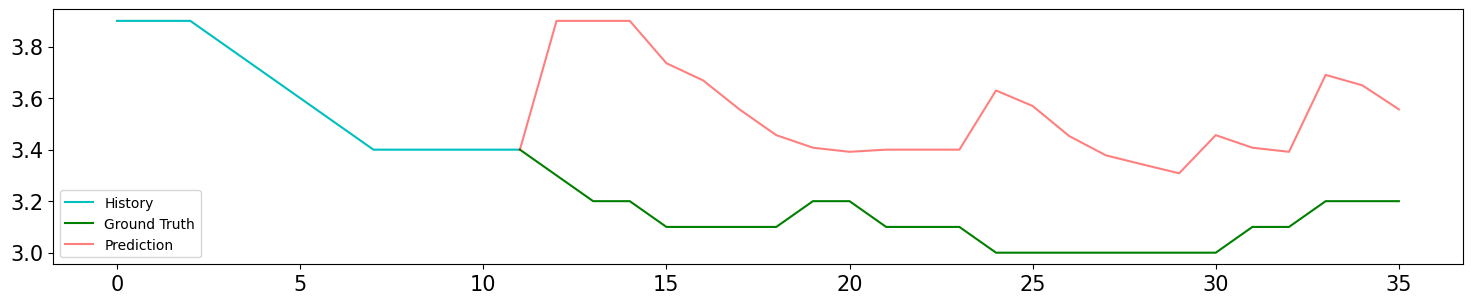

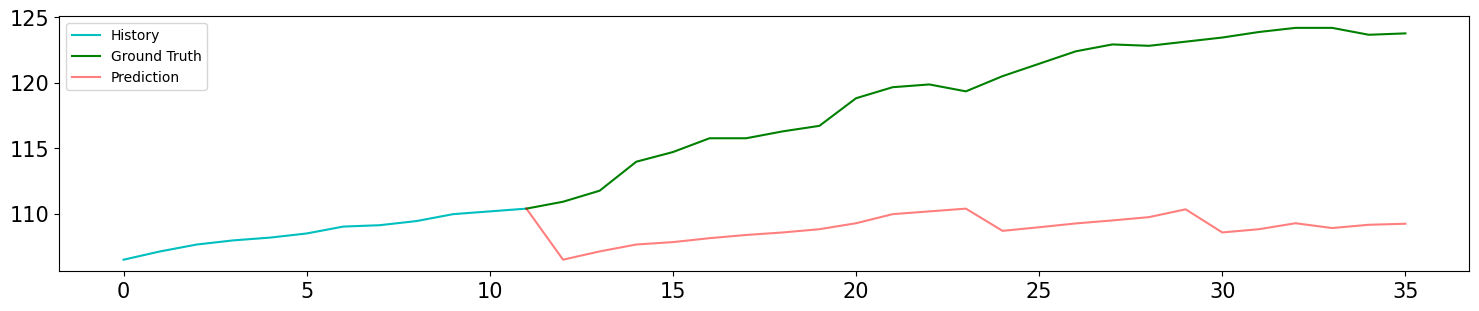

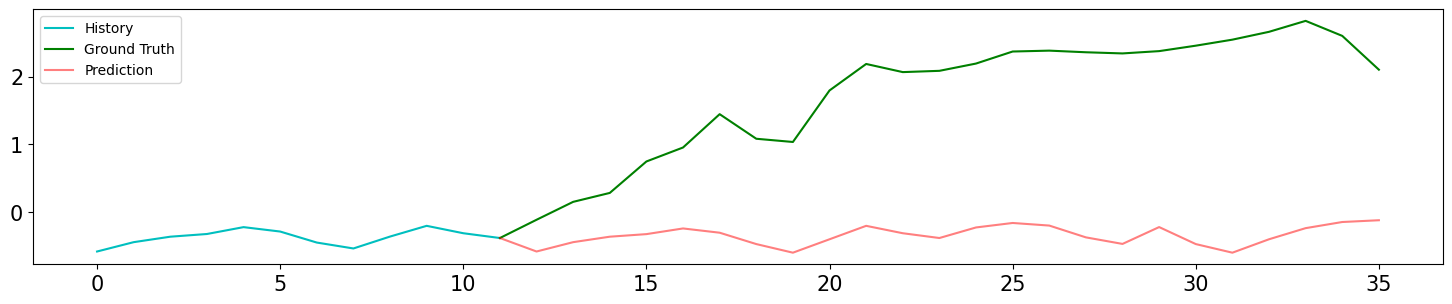

In [13]:
bekannt = 12
ende = 36

for idx in range(4):
    plt.figure(figsize=(15, 3))
    plt.plot(range(0, bekannt), test.iloc[:bekannt,idx], color='c', linestyle='solid', label='History')
    plt.plot(range(bekannt-1, ende), test.iloc[bekannt-1:ende,idx], color='g', linestyle='solid', label='Ground Truth')
    plt.plot(range(bekannt-1, ende), gen_real[bekannt-1:ende, idx], color='r', linestyle='solid', label='Prediction',alpha = 0.5)
    plt.tick_params('both', labelsize=15)
    plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
    plt.legend()
    plt.show()